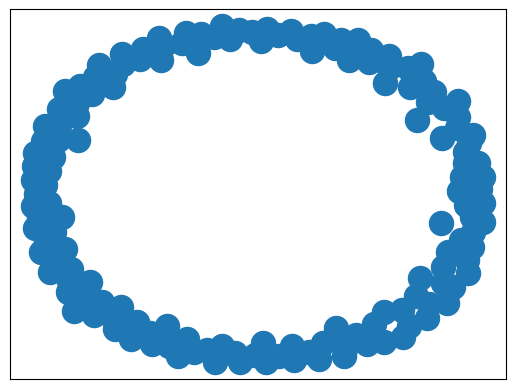

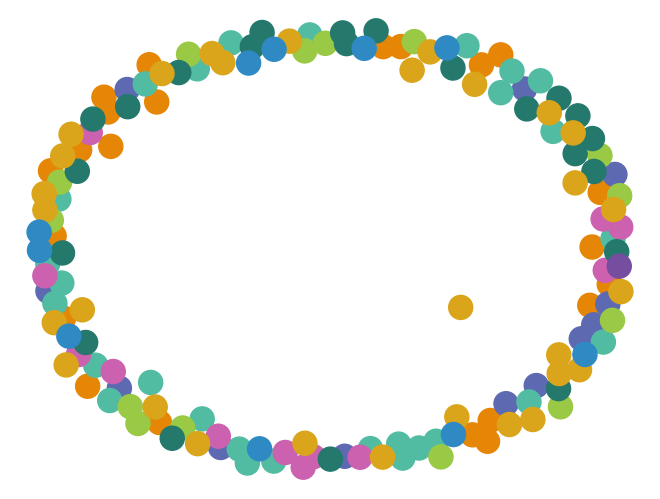

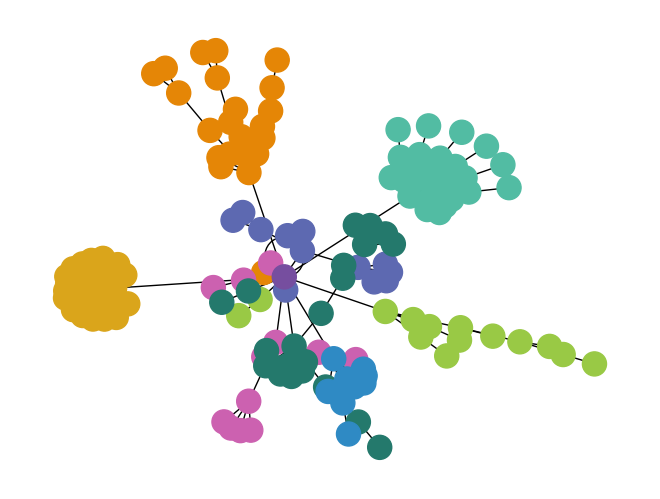

Coercing column 'status' to `list`
Coercing column 'languages' to `list`
Coercing column 'status' to `list`
Coercing column 'languages' to `list`


In [13]:
%run "../Part 1 - The Graph/Solution.ipynb"

Now we can take extra info (attributes) of each person (node) and map those onto nodes. This will allow us to connect people *through* common attributes, and not just through relationships like "reporting structure" or "hierarchy"

In [14]:
from itertools import chain
from more_itertools import always_iterable

def add_nodes_from_attributes(G: nx.Graph, *, attribute:str, default=[], flag:str):
    attributes = {person:attribute for person, attribute in G.nodes(data=attribute, default=default) if attribute}
    print(attributes)
    for attr in set(chain.from_iterable((always_iterable(value) for value in attributes.values()))):
        if attr:
            G.add_node(attr, **{flag: True, "type":flag})
        
add_nodes_from_attributes(G, attribute="languages", flag="language")
#add_nodes_from_attributes(G, attribute="apps", flag="app")
add_nodes_from_attributes(G, attribute="tz", flag="timezone", default="")

{'Kristopher Bauer': {'JavaScript'}, 'Timothy Hernandez': {'Scala', 'Go', 'Typescript', 'JavaScript', 'Java', 'Python'}, 'Mr. Cody Spencer': {'Typescript', 'Java', 'JavaScript'}, 'Renee Lin': {'Java'}, 'Ashley Carlson': {'Java', 'JavaScript'}, 'Marie Jacobson': {'Typescript', 'Java', 'JavaScript'}, 'Tara Shaw': {'Typescript', 'JavaScript', 'Python'}, 'Shannon Suarez': {'Java', 'Python'}, 'Jessica Flores': {'Java', 'Python', 'Erlang'}, 'Michelle Wu': {'Typescript', 'Python', 'Java', 'Go'}, 'Michael Morales': {'Typescript', 'Java', 'JavaScript', 'Python'}, 'Ann Harvey': {'Scala', 'Java'}, 'Shirley Smith': {'JavaScript', 'Python'}, 'Jeffrey Rodriguez': {'Java', 'JavaScript'}, 'Holly Burns': {'Scala', 'JavaScript'}, 'Kathleen Finley PhD': {'Scala', 'Java', 'Typescript', 'JavaScript'}, 'Tyler Gilmore': {'Scala', 'Python'}, 'Christopher Sanders': {'Typescript'}, 'Holly Luna': {'Typescript', 'Java', 'JavaScript'}, 'Lori Walter': {'Typescript', 'Java', 'JavaScript'}, 'Edward Price': {'Scala', 

Let's add the edges in now connecting people to the app/language nodes!

In [15]:
from more_itertools import always_iterable

def just_people(G):
    return lambda n: G.nodes()[n].get("person")

def add_edges_from_attributes(G:nx.Graph, *, attribute:str, weight:int=1):
    nodes = G.nodes()
    for name, attributes in nx.subgraph_view(G, filter_node=just_people(G)).nodes(data=attribute):
        for attr in always_iterable(attributes):
            if attr in nodes:
                G.add_edge(name, attr, weight=weight, **{attribute:True})

In [16]:
add_edges_from_attributes(G, attribute="languages")
add_edges_from_attributes(G, attribute="tz")
#add_edges_from_attributes(G, attribute="apps")
#add_edges_from_attributes(G, attribute="manager")

This should look interesting! We used a **force-directed layout** to draw the graph, meaning that the edges between nodes are **pulling** the nodes together in order until they find an equilibrium point. This also takes into account the weights we applied to edges, with higher weighed edges behaving like springs with higher spring constants

In [18]:
px_plot_nx(G, height=800, hover_name="label", color="team", size="rank", with_edges=True, template="plotly_dark")

Coercing column 'status' to `list`
Coercing column 'languages' to `list`


## Who are my people?

Let's use a few methods to investigate how the *people* nodes in the graph are connected and see if we can find clusters and *neighbourhoods*

We can look at just a "neighbourhood" around a person ... but this is currently unweighted, so we're just seeing anything 1 node away, instead of looking at a more complete view of "closeness"

In [ ]:
ego = nx.ego_graph(G, "Lucas", undirected=True, radius=3)
ego_people = nx.subgraph_view(ego, filter_node=just_people(G)).nodes()
nx.draw_networkx(ego, nodelist=ego_people)

This information is also easy to recover frbom the Graph itself

In [ ]:
connectivity = nx.all_pairs_node_connectivity(G, nbunch=peoplenodes)
connectivity

We can also look at where nodes get placed in our force-directed graph and look for closeness there

In [ ]:
import numpy as np
import xarray as xr

positions = {
    name: pos for name, pos in nx.spring_layout(G).items() if name in peoplenodes
}
positions = xr.DataArray(
    list(positions.values()),
    coords={"person": list(positions), "position": ["x", "y"]},
    dims=["person", "position"],
    attrs=dict(description="Node locations in a force-directed layout"),
)
positions

We can now do some matrix math to find the pairwise euclidean distances between each node!

In [ ]:
similarities = np.sqrt(((positions - positions.rename(person="person2"))**2).sum("position"))
similarities.name = "distance"
similarities

<xarray.DataArray 'distance' (person: 5, person2: 5)>
array([[0.        , 0.2496154 , 0.71110981, 0.41045877, 0.60896905],
       [0.2496154 , 0.        , 0.95934164, 0.4361895 , 0.58593751],
       [0.71110981, 0.95934164, 0.        , 0.92661015, 1.10974966],
       [0.41045877, 0.4361895 , 0.92661015, 0.        , 0.20481211],
       [0.60896905, 0.58593751, 1.10974966, 0.20481211, 0.        ]])
Coordinates:
  * person   (person) <U7 'Lucas' 'Taylor' 'Robert' 'Liz' 'New Guy'
  * person2  (person2) <U7 'Lucas' 'Taylor' 'Robert' 'Liz' 'New Guy'

In [ ]:
friends = similarities.sel(person="Lucas").sortby(similarities.sel(person="Lucas"))
friends[:2].person2

<xarray.DataArray 'person2' (person2: 2)>
array(['Lucas', 'Taylor'], dtype='<U7')
Coordinates:
    person   <U7 'Lucas'
  * person2  (person2) <U7 'Lucas' 'Taylor'